In [33]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
import re
import os
from bs4 import BeautifulSoup as bs
import folium

Onderstaande code leest het bestand `chronicle_cities.csv` als tabel met informatie over de kronieksteden, en de hoogte- en breedtegraad van deze stad op de kaart.

Vervolgens wordt deze data geprojecteerd op een kaart via `Folium`. Als een stad deel uitmaakt van het onderzoekscorpus, wordt deze rood gekleurd. Anders groen.  

In [34]:
corpus_cities = pd.read_csv('data/chronicle_cities.csv')

map_center = [corpus_cities['latitude'].mean(), corpus_cities['longitude'].mean()]
chronicle_map = folium.Map(location = map_center, zoom_start = 8)

for index, row in corpus_cities.iterrows():
    fill_color = '#3AB795' if row['stad'] in ['Middelburg', 'Amsterdam', 'Zierikzee', 'Oisterwijk', 'Culemborg', 'Steenwijk', 's-Hertogenbosch', 'Haarlem', 'Utrecht'] else '#FFCF56'
    
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=10,
        color='white',
        fill=True,
        fill_color=fill_color,
        fill_opacity=1,
    ).add_to(chronicle_map)

chronicle_map.save('output/chronicle_cities.html')
chronicle_map

De data uit `corpus.ndjson` wordt ingeladen als tabel. Er wordt een nieuwe kolom aangemaakt met het jaartal in de datumbeschrijving (`datum`). Als er geen waarde in de cel voor de kolom `datum` is, wordt deze genoteerd als missende waarde (`NaN`). 

Om het corpus inzichtelijk te maken, worden de rijen voor elke unieke waarde voor `kroniek` samengevoegd en geprint. 

In [35]:
dir = os.getcwd() + '\\'
corpus = 'data/corpus.njdson'

corpus_dataframe = []

with open(dir + corpus, 'r', encoding = 'utf-8') as corpusFile:
    for line in corpusFile:
        data = json.loads(line)

        if 'date' in data and data['date'] != 'NaN_before_date' and data['date']:
            if isinstance(data['date'][0], str):
                date = data['date'][0][:4]
            else:
                date = 'NaN'
        else:
            date = 'NaN'

        corpus_dataframe.append({
            'kroniek': data.get('call_nr', ''), 
            'tekst': data.get('text', ''),
            'datum': data.get('date', ''),
            'jaartal': date
        })

corpus_dataframe = pd.DataFrame(corpus_dataframe)
corpus_dataframe.groupby('kroniek').head(1)

,kroniek,tekst,datum,jaartal
0,1602_Midd_Joos,De kroniek van Pieter Joossen Altijt Recht Hou...,NaN_before_date,NaN
12,1570_Rott_Alle,1 Rotterdamse kroniek Aantekeningen van Rotter...,NaN_before_date,NaN
161,1579_Amst_Maes,,NaN_before_date,NaN
1448,1576_Zier_Clae,"<persoonsnaam> Jonkheer Hieronimus de Rollé,...",[1571-08-08],1571
1476,1583_Bilt_ErpH,Editie Uyt seecker out boek geschreven door de...,NaN_before_date,NaN
1562,1609_Oist_Hoev,,NaN_before_date,NaN
1659,1592_Cule_Vrem,"Int jaer <datum datum=""1492-xx-xx"">duysent vi...",[1492-xx-xx],1492
1723,1582_Stee_Steg,Aantekeningen over <locatie>Steenwijk</locatie...,NaN_before_date,NaN
1761,1609_Bosc_Anon,narratio rerum sylvaducensium Verhael van het ...,NaN_before_date,NaN
1889,1575_Hoor_Matt,Rijksarchief Noord-Holland Losse aanwinsten 15...,NaN_before_date,NaN


In [36]:
corpus_range = corpus_dataframe.copy()
corpus_range['jaartal'] = corpus_range['jaartal']
corpus_range.columns = ['kroniek', 'tekst', 'specifieke_datum', 'datum']

corpus_range['datum'] = pd.to_numeric(corpus_range['datum'], errors='coerce')

ranges = [(0, 1567), (1568, 1609)]

period_counts = pd.DataFrame(columns=['kroniek'] + [f'{start}-{end}' for start, end in ranges])

for chronicle in corpus_range['kroniek'].unique():
    chronicle_data = corpus_range[corpus_range['kroniek'] == chronicle]
    counts = []
    
    for start, end in ranges:
        count = len(chronicle_data[(chronicle_data['datum'] >= start) & (chronicle_data['datum'] <= end)])
        counts.append(count)
    
    period_counts.loc[len(period_counts)] = [chronicle] + counts 

period_counts.set_index('kroniek', inplace=True)
period_counts.sort_index(inplace=True)


In [37]:
print('Telling van het totale aantal gebeurtenissen in de bepaalde perioden:')
print(period_counts.sum(), '\n')

print('Tabel met het aantal gebeurtenissen per kroniek in de bepaalde perioden:')
print(period_counts)

Telling van het totale aantal gebeurtenissen in de bepaalde perioden:
0-1567        323
1568-1609    2475
dtype: int64 

Tabel met het aantal gebeurtenissen per kroniek in de bepaalde perioden:
                0-1567  1568-1609
kroniek                          
1570_Rott_Alle     147          1
1575_Hoor_Matt       0          0
1576_Zier_Clae       0         24
1577_Utre_Anon       1         18
1579_Amst_Maes       6       1276
1581_Haar_Verw       2        914
1582_Stee_Steg      12         25
1583_Bilt_ErpH      82          3
1592_Cule_Vrem      12         52
1602_Midd_Joos       4          7
1609_Bosc_Anon      39         81
1609_Oist_Hoev      18         74


De data worden gefilterd. Als een kroniek voor de periode 1568-1609 meer dan vijf beschrijvingen bevat, wordt deze bewaard in het corpus.

In [38]:
dropped_chronicles = period_counts[period_counts['1568-1609'] > 5].index
corpus_dataframe = corpus_dataframe[corpus_dataframe['kroniek'].isin(dropped_chronicles)]

De gefilterde data wordt opgeslagen als `corpus_1568-1609.ndjson`. Op basis van dit bestand worden de overige programma's uitgevoerd.

In [39]:
corpus_dataframe.to_json(dir + 'data/corpus_1568-1609.ndjson', orient='records', lines=True) 

Op basis van een reguliere expressie (`regex`) worden de locatie en datum-tags verzameld. 

In [40]:
def extract_unique_locations(text, tag):
    unique_variations = []
    soup = bs(text, 'html.parser')
    tags = soup.find_all(tag)
    unique_variations.extend(tag.text.strip() for tag in tags)

    return len(unique_variations)

tag_counts = {}

for chronicle in corpus_dataframe['kroniek'].unique():
    chronicle_data = corpus_dataframe[corpus_dataframe['kroniek'] == chronicle]
    chronicle_text = chronicle_data['tekst'].str.cat(sep=' ')
    
    locatie_count = extract_unique_locations(chronicle_text, 'locatie')
    datum_count = extract_unique_locations(chronicle_text, 'datum')
    persoonsnaam_count = extract_unique_locations(chronicle_text, 'persoonsnaam')

    tag_counts[chronicle] = {'locaties': locatie_count, 'datums': datum_count, 'persoonsnamen': persoonsnaam_count}

tag_counts_dataframe = pd.DataFrame.from_dict(tag_counts, orient='index')
tag_counts_dataframe.index.name = 'kroniek'
tag_counts_dataframe

,locaties,datums,persoonsnamen
kroniek,,,
1602_Midd_Joos,157,17,47
1579_Amst_Maes,4329,1393,1258
1576_Zier_Clae,208,33,112
1609_Oist_Hoev,292,115,100
1592_Cule_Vrem,268,103,84
1582_Stee_Steg,143,39,66
1609_Bosc_Anon,474,138,296
1581_Haar_Verw,1672,1026,1292
1577_Utre_Anon,295,40,77


Om een overzicht te krijgen van de relatieve verdeling van het aantal tags over de tekst, wordt in de volgende code het aantal woorden in de kroniek geplaatst in verhouding met het aantal tags. 

Eerst wordt het totaal aantal worden voor elke kroniek geteld. Vervolgens wordt berekend hoe frequent een tag voorkomt in de tekst via deel/geheel\*100 of (tag/woordaantal\*100)

In [41]:
word_count_series = corpus_dataframe.groupby('kroniek')['tekst'].apply(lambda x: x.apply(lambda y: len(y.split())).sum())
word_counts_dataframe = word_count_series.reset_index(name='Woordenaantal')

merged_dataframe = tag_counts_dataframe.merge(word_counts_dataframe, on='kroniek')

merged_dataframe['frequentie locaties'] = merged_dataframe['locaties'] / merged_dataframe['Woordenaantal'] * 100
merged_dataframe['frequentie datums'] = merged_dataframe['datums'] / merged_dataframe['Woordenaantal'] * 100
merged_dataframe['frequentie persoonsnamen'] = merged_dataframe['persoonsnamen'] / merged_dataframe['Woordenaantal'] * 100

relative_frequency_dataframe = merged_dataframe[['kroniek', 'frequentie locaties', 'frequentie datums', 'frequentie persoonsnamen']].set_index('kroniek').sort_index()


In [42]:
print('Tabel met het aantal woorden per kroniek:')
word_counts_dataframe

Tabel met het aantal woorden per kroniek:


,kroniek,Woordenaantal
0,1576_Zier_Clae,8372
1,1577_Utre_Anon,13615
2,1579_Amst_Maes,226423
3,1581_Haar_Verw,78072
4,1582_Stee_Steg,3444
5,1592_Cule_Vrem,5556
6,1602_Midd_Joos,6641
7,1609_Bosc_Anon,34854
8,1609_Oist_Hoev,6858


Onderstaande staafdiagram geeft inzicht in de verdeling van het aantal tags in de kronieken.

In [43]:
relative_frequency_dataframe

,frequentie locaties,frequentie datums,frequentie persoonsnamen
kroniek,,,
1576_Zier_Clae,2.484472,0.394171,1.337793
1577_Utre_Anon,2.166728,0.293794,0.565553
1579_Amst_Maes,1.911908,0.615220,0.555597
1581_Haar_Verw,2.141613,1.314172,1.654883
1582_Stee_Steg,4.152149,1.132404,1.916376
1592_Cule_Vrem,4.823614,1.853852,1.511879
1602_Midd_Joos,2.364102,0.255986,0.707725
1609_Bosc_Anon,1.359959,0.395937,0.849257
1609_Oist_Hoev,4.257801,1.676874,1.458151


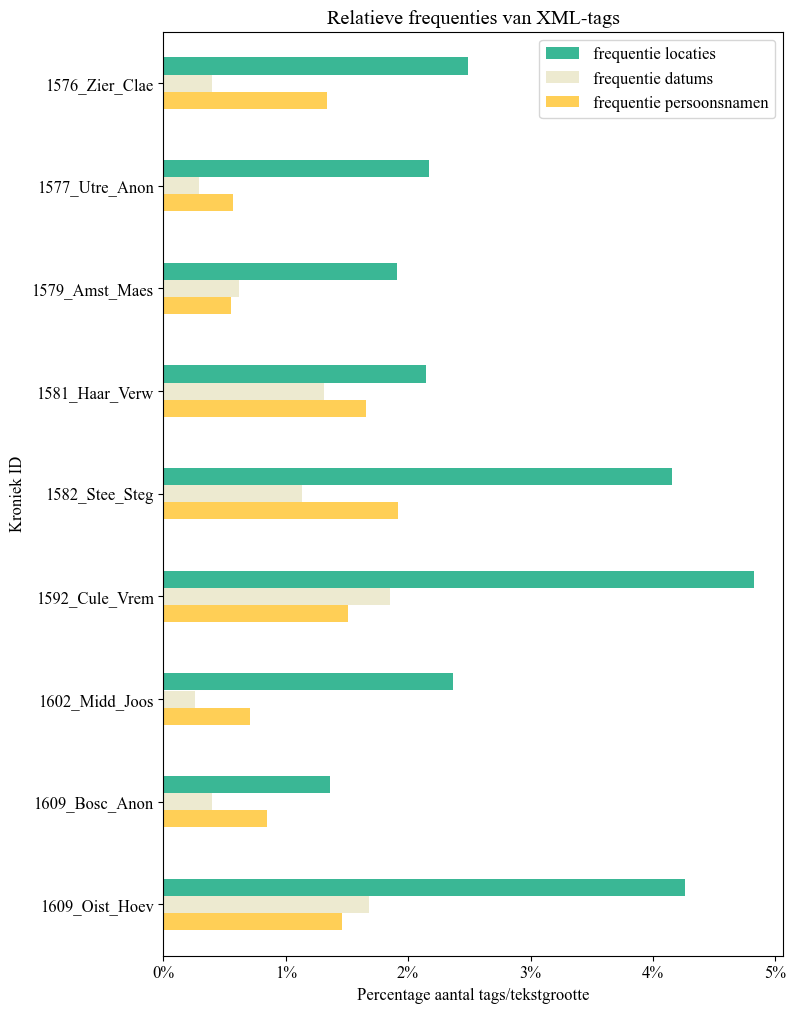

In [44]:
fig, ax = plt.subplots(figsize=(8, 12))
plt.rcParams.update({'font.family': 'Times New Roman', 'font.size': 12})

colors = ['#3AB795', '#EDEAD0', '#FFCF56']

relative_frequency_dataframe.plot(kind='barh', stacked=False, ax=ax, color=colors)

ax.legend()
ax.invert_yaxis()

plt.title('Relatieve frequenties van XML-tags')
plt.ylabel('Kroniek ID')
plt.xlabel('Percentage aantal tags/tekstgrootte')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals = 0))
output_path = os.path.join(dir, 'output', 'relatieve_frequenties_tags.svg')
plt.savefig(output_path, format='svg', dpi=300, bbox_inches='tight')

plt.show()

De volgende code verzamelt informatie over het bereik van de kronieken. Daarbij wordt gebruikgemaakt van vier datapunten: de eerste datum, de laatste datum, het jaartal 1568 en het jaartal 1609.

In [45]:
corpus_range = corpus_dataframe.copy()

corpus_range = corpus_range[corpus_range['jaartal'] != 'NaN']
corpus_range = corpus_range.groupby('kroniek').agg(first_date=('jaartal', 'min'), last_date=('kroniek', lambda x: x.str[:4].max())).reset_index().set_index('kroniek')

merged_date_range = pd.DataFrame({
    'L2': corpus_range['first_date'].astype(int),
    'L1': corpus_range['first_date'].astype(int).clip(lower = 1568),
    'R1': corpus_range['last_date'].astype(int).clip(upper = 1609),
    'R2': corpus_range['last_date'].astype(int)
}).set_index(corpus_range.index)

In [46]:
print('Tabel met het bereik van de kronieken:')
corpus_range

Tabel met het bereik van de kronieken:


,first_date,last_date
kroniek,,
1576_Zier_Clae,1571,1576
1577_Utre_Anon,1566,1577
1579_Amst_Maes,1173,1579
1581_Haar_Verw,1530,1581
1582_Stee_Steg,1216,1582
1592_Cule_Vrem,1492,1592
1602_Midd_Joos,1551,1602
1609_Bosc_Anon,1206,1609
1609_Oist_Hoev,1230,1609


De tijdlijn gebruikt de data uit `corpus_range` om een overzicht te geven van het bereik van de kronieken. 

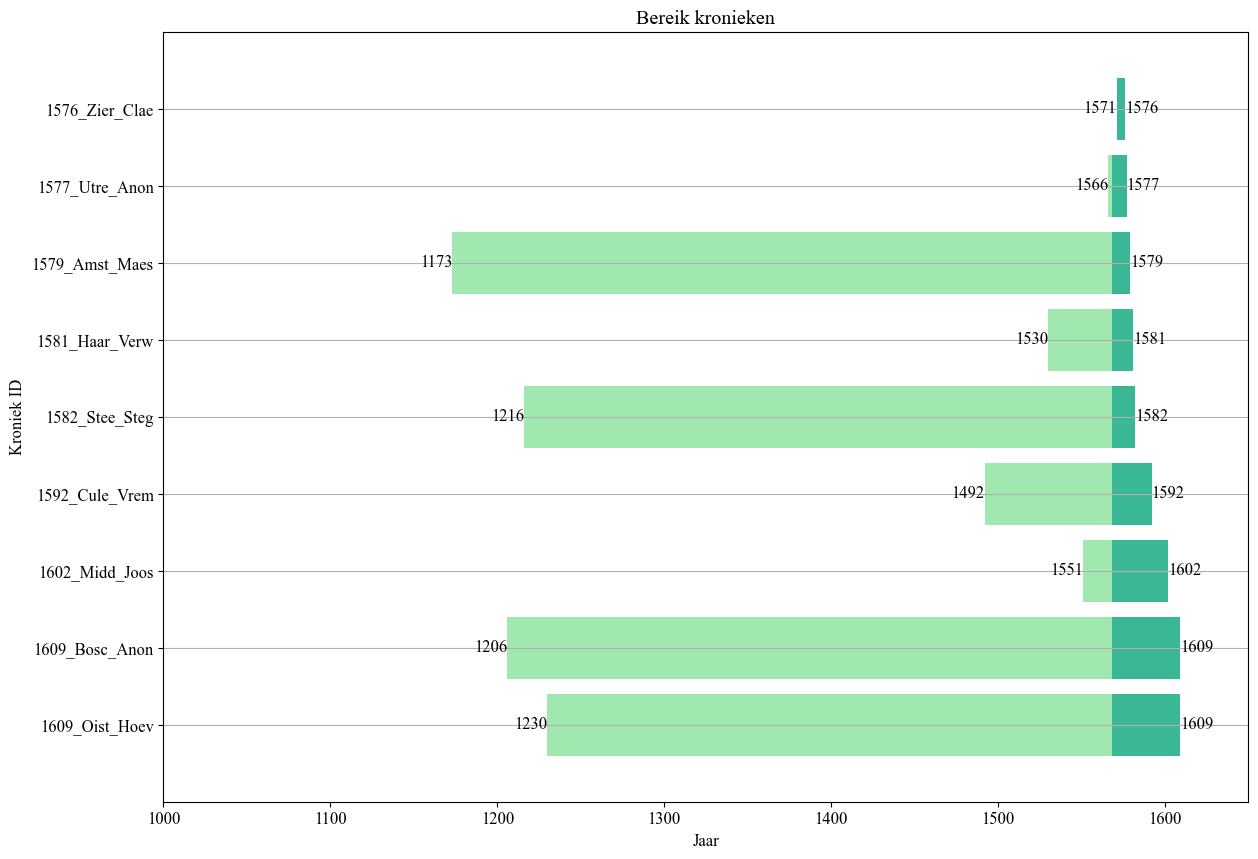

In [47]:
fig, ax = plt.subplots(figsize=(14, 10))
colors = ['#A0E8AF', '#3AB795', '#A0E8AF']

for i, (index, row) in enumerate(merged_date_range.iterrows()):
    widths = [row['L1'] - row['L2'], row['R1'] - row['L1'], row['R2'] - row['R1']]
    lefts = [row['L2'], row['L1'], row['R1']]

    for width, left, color in zip(widths, lefts, colors):
        ax.barh(i, width, left=left, color=color)

    ax.text(row['L2'], i, str(row['L2']), ha='right', va='center')
    ax.text(row['R2'], i, str(row['R2']), ha='left', va='center')

ax.set_yticks(range(len(merged_date_range)))
ax.set_yticklabels(merged_date_range.index.astype(str))

ax.grid(axis='y', linestyle='-')
ax.set_ylim(len(merged_date_range), -1)
ax.set_xlim(1000, 1650)
ax.set_xticks(range(1000, 1651, 100))
ax.set_ylabel('Kroniek ID')
ax.set_xlabel('Jaar')
ax.set_title('Bereik kronieken')

output_path = os.path.join(dir, 'output', 'kronieken_bereik.svg')

plt.savefig(output_path, format='svg', dpi=300, bbox_inches='tight')
plt.show()

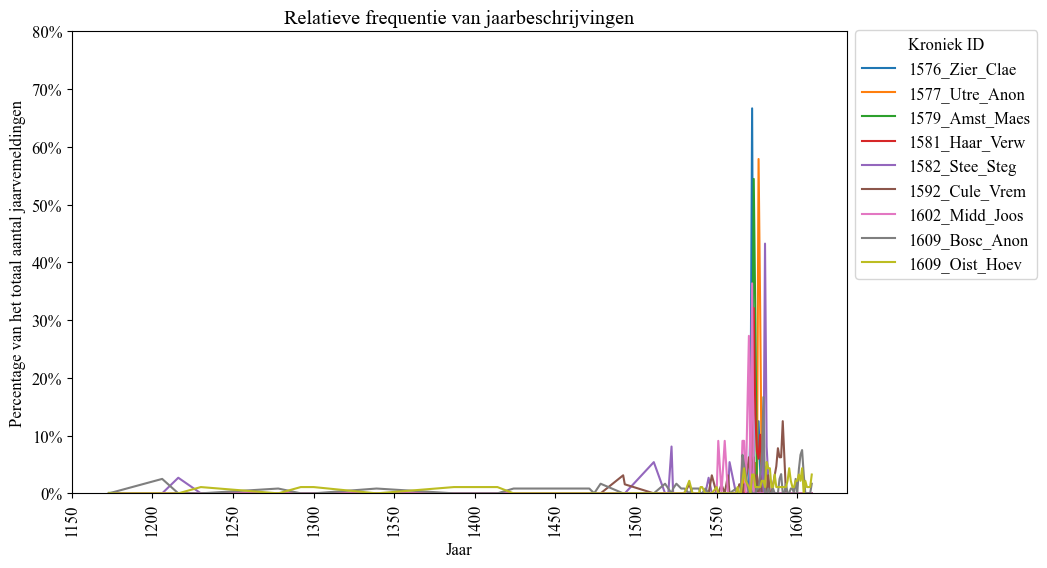

In [48]:
year_counts_dataframe = corpus_dataframe.groupby(['kroniek', 'jaartal']).size().reset_index(name='count')
year_counts_dataframe = year_counts_dataframe[year_counts_dataframe['jaartal'].str.isnumeric()]
total_counts = year_counts_dataframe.groupby('kroniek')['count'].transform('sum')
year_counts_dataframe['relative_frequency'] = year_counts_dataframe['count'] / total_counts * 100
year_counts_pivot = year_counts_dataframe.pivot_table(index='jaartal', columns='kroniek', values='relative_frequency', fill_value=0)
year_counts_pivot.index = pd.to_numeric(year_counts_pivot.index, errors='coerce')

fig, ax = plt.subplots(figsize=(10, 6))
year_counts_pivot.plot.line(ax=ax)
ax.set_xlabel('Jaar')
ax.set_ylabel('Percentage van het totaal aantal jaarvemeldingen')
ax.set_title('Relatieve frequentie van jaarbeschrijvingen')
min_year = year_counts_pivot.index.min()
max_year = year_counts_pivot.index.max()
plt.xticks(range(1150, 1625 + 1, 50), rotation=90)

ax.legend(title='Kroniek ID', bbox_to_anchor=(1.0, 1.02), loc='upper left')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.ylim(0, 80)
output_path = os.path.join(dir, 'output', 'relative_frequency_year_descriptions_kronieken.svg')
plt.savefig(output_path, format='svg', dpi=300, bbox_inches='tight')
plt.show()

In [49]:
corpus_range = corpus_dataframe.copy()
corpus_range['jaartal'] = corpus_range['jaartal']
corpus_range.columns = ['kroniek', 'tekst', 'specifieke_datum', 'datum']

corpus_range['datum'] = pd.to_numeric(corpus_range['datum'], errors='coerce')

ranges = [(1150, 1200), (1200, 1250), (1250, 1300), (1300, 1350), (1350, 1400), (1400, 1450), (1450, 1500), (1500, 1550), (1550, 1600), (1600, 1650)]

period_counts = pd.DataFrame(columns=['kroniek'] + [f'{start}-{end}' for start, end in ranges])

for chronicle in corpus_range['kroniek'].unique():
    chronicle_data = corpus_range[corpus_range['kroniek'] == chronicle]
    counts = []
    
    for start, end in ranges:
        count = len(chronicle_data[(chronicle_data['datum'] >= start) & (chronicle_data['datum'] <= end)])
        counts.append(count)
    
    period_counts.loc[len(period_counts)] = [chronicle] + counts 

period_counts.set_index('kroniek', inplace=True)
period_counts.sort_index(inplace=True)
period_counts.to_csv('output/period_counts.csv')